## **CNN MODEL**


-	אגריגציה של time stamps לפי ערך מקסימלי.
-	התמודדות עם סדרות זמן בגדלים שונים- הפיכת כל הסדרות לאותו גודל (שנקבע על פי הגודל של הסדרה בעלת האורך המינימלי) באופן הבא: (מהמאמר שאיליה שלח) 
 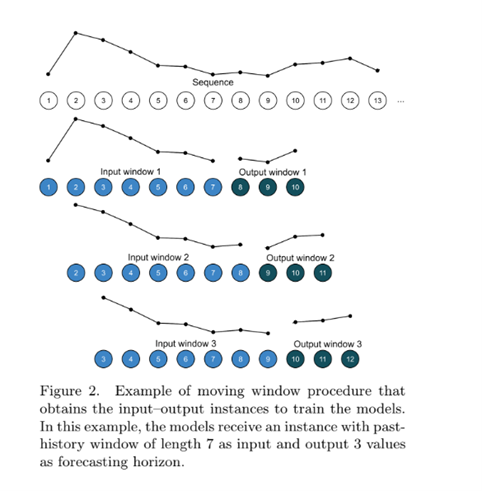
-	הפרמטרים שקבענו במודל CNN:
epochs = 50
batch size = 64
kernel = [7, 5, 3, 3] (4 convolution layers)
number of filter = 64
pooling size = 1
learning rate = 0.0001
Learning rate decay at epochs 5 and 10
Forecast horizon = 10
תוצאות חיזוי של CNN: 
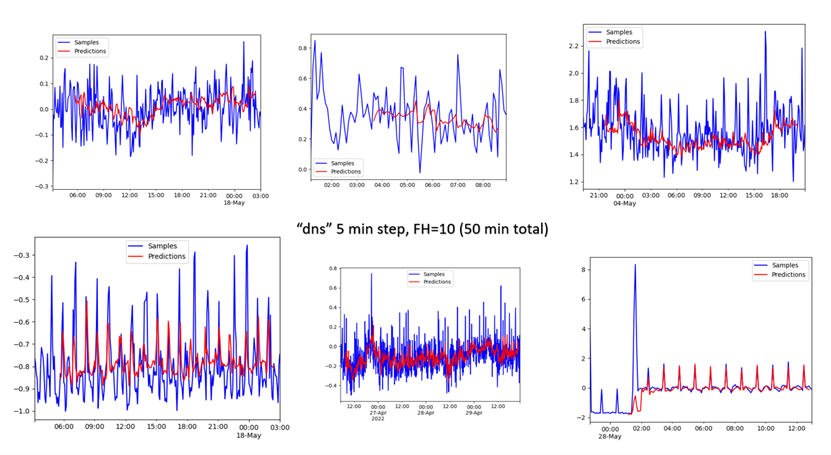
-	תובנות על CNN:
 CNN הוא מודל שיודע ללמוד ולזהות תבניות מחזוריות. CNN יודע להסתכל על נקודות זמן שכנות ולהבין קשרים ביניהן.
כשלנתונים אין התנהגות ברורה,CNN  בד"כ ייקח את הממוצע.



In [ ]:
import torch.nn as nn
import torch.optim as optim
import torch
import numpy as np
import pytorch__driver_for_test_bench as pytorch__driver_for_test_bench

"""
creating CNN for time series prediction.
"""



import argparse

parser = argparse.ArgumentParser()
parser.add_argument('--epochs', type=int, default=30, metavar='N', help='number of epochs')
parser.add_argument('--batch_size', type=int, default=64, metavar='N', help='batch size')
parser.add_argument('--save_num', type=int, default=1, metavar='N', help='number on the file to save')
parser.add_argument('--integers', metavar='N', type=int, nargs='+',help='lr decay')
parser.add_argument('--kernel', metavar='N', type=int, nargs='+',help='kernel sizes')
parser.add_argument('--filter_num', type=int, default=16, metavar='N', help='number of filters')
parser.add_argument('--pooling_size', type=int, default=1, metavar='N', help='pooling size')
parser.add_argument('--lr', type=float, default=0.0001, metavar='N', help='learning rate')
parser.add_argument('--seed', type=int, default=0, metavar='N', help='seed')
parser.add_argument("--overparam", type=bool, default=False, help="more parameters")

args = parser.parse_args()


with open('params_' + str(args.save_num) + '.txt', 'w') as f:
    f.write("epochs = "+str(args.epochs) + '\n' + "batch size = "+str(args.batch_size) + '\n' + "kernel = "+str(args.kernel)
            + '\n' + "number of filter = "+str(args.filter_num) + '\n' + "pooling size = "+str(args.pooling_size) + '\n'
            + "learning rate = "+str(args.lr) + '\n' + "lr decay at epochs: "+str(args.integers) + '\n' + "seed = "+str(args.seed))

np.random.seed(args.seed)
torch.manual_seed(args.seed)

class CNNPredictor(nn.Module):
    def __init__(self, input_size, output_size, length_of_shortest_time_series, pooling_size,
                 kernel_size, num_of_filters, overparam=False):
        super(CNNPredictor, self).__init__()
        self.__length_of_shortest_time_series = length_of_shortest_time_series
        self.pooling_size = pooling_size
        self.kernel_size = kernel_size
        self.num_of_filters = num_of_filters

        # calculate the first fully connected layer size
        fully_connected_features = length_of_shortest_time_series
        for i in range(len(kernel_size)):
            fully_connected_features = np.floor((fully_connected_features-kernel_size[i]+1)/pooling_size)
        fully_connected_features = num_of_filters * int(fully_connected_features)

        # build the model
        for i in range(len(kernel_size)):
            if i == 0:
                self.__seq_model = nn.Sequential(
                    nn.Conv1d(
                        in_channels=input_size,
                        out_channels=num_of_filters,
                        kernel_size=kernel_size[i],
                        stride=1,
                        padding=0
                    ),
                    nn.ReLU(),
                    nn.MaxPool1d(kernel_size=pooling_size),
                )
            else:
                self.__seq_model.add_module(
                    'conv' + str(i),
                    module=nn.Conv1d(
                        in_channels=num_of_filters,
                        out_channels=num_of_filters,
                        kernel_size=kernel_size[i],
                        stride=1,
                        padding=0
                    )

                )
                self.__seq_model.add_module(
                    'relu' + str(i),
                    module=nn.ReLU()
                )
                self.__seq_model.add_module(
                    'pool' + str(i),
                    module=nn.MaxPool1d(kernel_size=pooling_size)
                )

        self.__seq_model.add_module('flatten', nn.Flatten())
        if not overparam:
            self.__seq_model.add_module('linear1', module=nn.Linear(in_features=fully_connected_features, out_features=20))
            self.__seq_model.add_module('relu_after_linear1', module=nn.ReLU())
            self.__seq_model.add_module('linear2', module=nn.Linear(in_features=20, out_features=output_size))
        else:
            self.__seq_model.add_module('linear1', module=nn.Linear(in_features=fully_connected_features, out_features=1500))
            self.__seq_model.add_module('relu_after_linear1', module=nn.ReLU())
            self.__seq_model.add_module('linear2', module=nn.Linear(in_features=1500, out_features=1000))
            self.__seq_model.add_module('relu_after_linear2', module=nn.ReLU())
            self.__seq_model.add_module('linear3', module=nn.Linear(in_features=1000, out_features=500))
            self.__seq_model.add_module('relu_after_linear3', module=nn.ReLU())
            self.__seq_model.add_module('linear4', module=nn.Linear(in_features=500, out_features=100))
            self.__seq_model.add_module('relu_after_linear4', module=nn.ReLU())
            self.__seq_model.add_module('linear5', module=nn.Linear(in_features=100, out_features=20))
            self.__seq_model.add_module('relu_after_linear5', module=nn.ReLU())
            self.__seq_model.add_module('linear6', module=nn.Linear(in_features=20, out_features=output_size))


    def forward(self, x):
        # use only the last "length_of_shortest_time_series" values of the time series
        x = x[:, :, -1*self.__length_of_shortest_time_series:]
        out = self.__seq_model(x)
        return out

    def flatten_parameters(self):
        pass


class PytorchCNNTester:
    def __init__(self, length_of_shortest_time_series, metric, app, model_name = "CNN"):
        # prepare parameters
        self.model_name = model_name
        self.__msg = "[PytorchCNNTester]"
        self.__model_input_length = length_of_shortest_time_series // 2
        self.__model = CNNPredictor(
            input_size=1,
            output_size=1,
            length_of_shortest_time_series=self.__model_input_length,
            pooling_size=args.pooling_size,
            kernel_size=args.kernel,
            num_of_filters=args.filter_num,
            overparam=args.overparam
        ).to(pytorch__driver_for_test_bench.get_device())
        # Some Hyper-parameters
        self.__optimizer = optim.Adam(self.__model.parameters(), lr=args.lr)
        self.__best_model = self.__model
        self.__criterion = nn.MSELoss()
        # prints
        print(self.__msg, f"model = {self.__model}")
        print(self.__msg, f"optimizer = {self.__optimizer}")
        print(self.__msg, f"criterion = {self.__criterion}")


    def learn_from_data_set(self, training_data_set):
        self.__best_model = pytorch__driver_for_test_bench.train_neural_network(
            training_data_set=training_data_set,
            model=self.__model,
            num_epochs=args.epochs,
            model_input_length=self.__model_input_length,
            batch_size=args.batch_size,
            criterion=self.__criterion,
            optimizer=self.__optimizer,
            model_name=self.model_name,
            save_num=args.save_num,
            lr_decay=args.integers
        )

    def predict(self, ts_as_df_start, how_much_to_predict):
        return pytorch__driver_for_test_bench.predict(
            ts_as_df_start=ts_as_df_start, how_much_to_predict=how_much_to_predict, best_model=self.__best_model,
            model_name="CNN"
        )

    def get_input_length(self):
        return self.__model_input_length


"""
***********************************************************************************************************************
    main function
***********************************************************************************************************************
"""


def main(test_to_perform):
    import framework__test_bench as framework__test_bench
    tb = framework__test_bench.TestBench(
        class_to_test=PytorchCNNTester,
        path_to_data="../data/",
        tests_to_perform=test_to_perform,
        model_name="CNN",
        number_to_save=args.save_num
    )
    tb.run_training_and_tests()


if __name__ == "__main__":
    test_to_perform = (
        # Container CPU
        {"metric": "container_cpu", "app": "dns", "prediction length": 10, "sub sample rate": 5,
         "data length limit": 60},
        {"metric": "container_cpu", "app": "dns", "prediction length": 10, "sub sample rate": 5,
         "data length limit": 60}
    )
    main(test_to_perform)
